# Вторая лабораторная

Базовые методы обработки изображений.

*В этом ноутбуке изначально опущены результаты исполнения кода. Рекомендуется запускать (Shift+Enter) ячейки по мере просмотра документа*

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread, imsave
from skimage.color import rgb2gray

## 1. Бинаризация

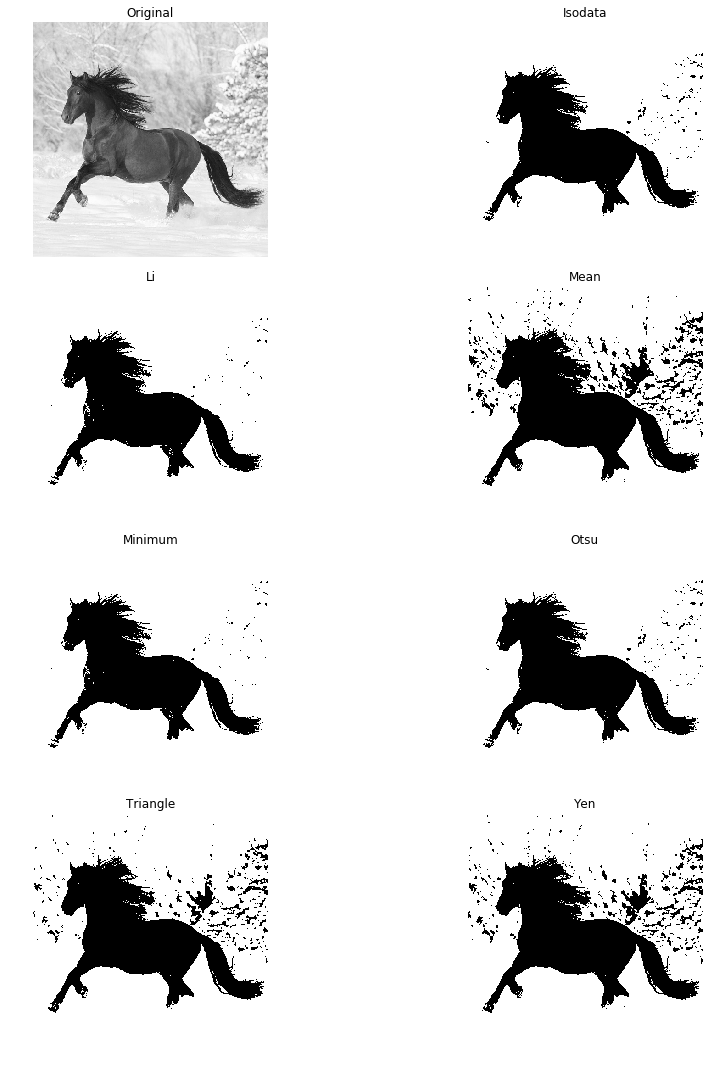

In [51]:
from skimage.filters import try_all_threshold

img = imread('./horse.jpg')
fig, ax = try_all_threshold(rgb2gray(img), figsize=(15, 15), verbose=False)
plt.show()

Посмотрим как можно улучшить результат с помощью предобработки:

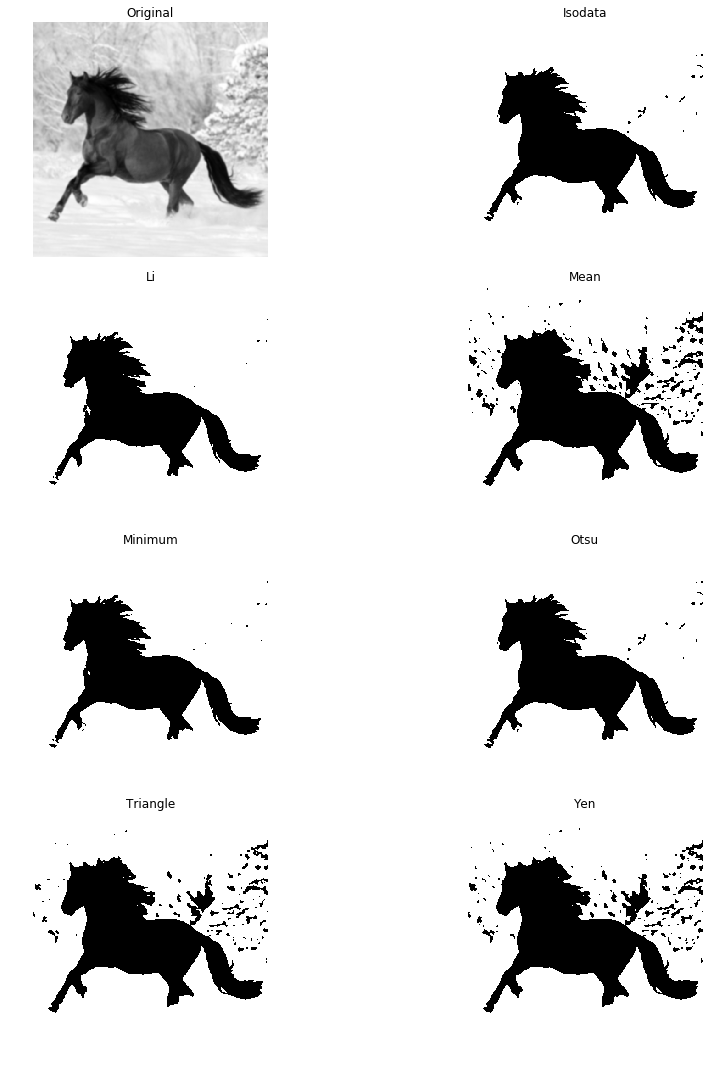

In [52]:
from skimage.filters import gaussian

img_blur = gaussian(img, sigma=1.5, multichannel=True)

fig, ax = try_all_threshold(rgb2gray(img_blur), figsize=(15, 15), verbose=False)
plt.show()

Рассмотрим результат бинаризации Оцу:

(-0.5, 511.5, 511.5, -0.5)

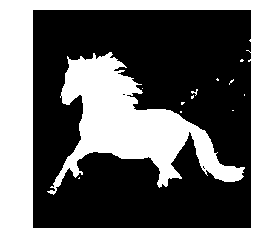

In [53]:
from skimage.filters import threshold_otsu

img_blur_gray = rgb2gray(img_blur)
thresh_otsu = threshold_otsu(img_blur_gray)
res_otsu = img_blur_gray <= thresh_otsu

plt.imshow(res_otsu, cmap='gray')
plt.axis('off')

Видно, что в целом результат неплохой, но справа от объекта осталось несколько мелких пятен.

Посмотрим как можно избавиться от этих пятен:

Нужные морфологические операции реализованы в библиотеке [skimage.morphology](http://scikit-image.org/docs/dev/api/skimage.morphology.html). Подключим их

(-0.5, 511.5, 511.5, -0.5)

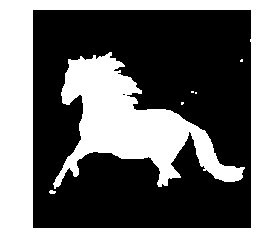

In [54]:
from skimage.morphology import binary_opening

res_otsu_enclosed = binary_opening(res_otsu, selem=np.ones((5, 5)))

plt.imshow(res_otsu_enclosed, cmap='gray')
plt.axis('off')

От части пятен удалось избавиться. При этом видно, что вблизи гривы маска стала значительно более гладкой, из-за применения `binary_opening`.

*Если бы внутри объекта были дырки, их можно было бы закрасить по аналогии, используя метод `binary_closing(img) = binary_erosion(binary_dilation(img))`.*

Проведём анализ компонент связности на маске:

Значения площади для каждой компоненты связности: [15, 56175, 40, 25, 25, 35, 115]
labels - матрица, заполненная индексами компонент связности со значениями из множества: [0 1 2 3 4 5 6 7]


(-0.5, 511.5, 511.5, -0.5)

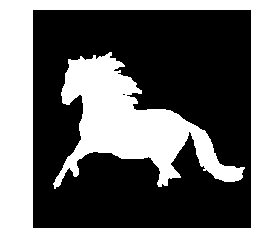

In [55]:
from skimage.measure import label, regionprops

def get_largest_component(mask):
    labels = label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности

    print("Значения площади для каждой компоненты связности: {}".format(areas))
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью

    print("labels - матрица, заполненная индексами компонент связности со значениями из множества: {}".format(np.unique(labels)))
    return labels == (largest_comp_id + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу

plt.imshow(get_largest_component(res_otsu_enclosed), cmap='gray')
plt.axis('off')

### Задание 1.

Подберите изображение, на котором объект достаточно чётко отделим от фона. Выделите на нём объект при помощи бинаризации, морфологических операций и анализа компонент связности, по аналогии с примером выше.

(-0.5, 499.5, 333.5, -0.5)

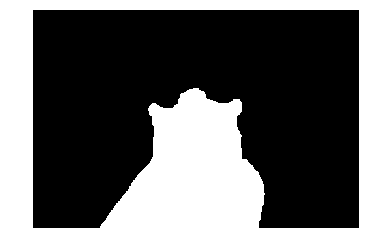

In [71]:
from skimage.morphology import binary_closing
#как и в примере выше я рассматриваю результат бинаризации Оцу, после него так же результат выделения объекта неплохой, но сверху есть помехи
first_image = imread('cat1.jpg')
img_blur = gaussian(first_image, sigma=1.5, multichannel=True)
img_blur_gray = rgb2gray(img_blur)
thresh_otsu = threshold_otsu(img_blur_gray)
res_otsu = img_blur_gray <= thresh_otsu
res_otsu_enclosed = binary_closing(res_otsu, selem=np.ones((15,15)))
plt.imshow(res_otsu_enclosed, cmap='gray')

plt.axis('off')


# Ваш код

**Локальные методы**

В случае, если объект отчётливо виден, но на изображении неравномерное освещение, полезны локальные методы.

Ниже приведены изображения, содержащие локальные пороговые значения:

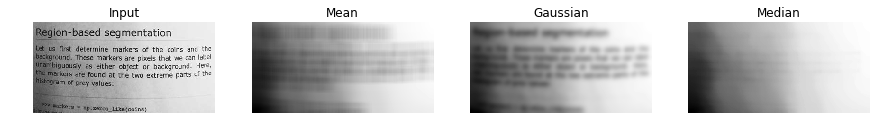

In [76]:
from skimage.data import page
from skimage.filters import threshold_local

page_img = rgb2gray(page())

fig, ax = plt.subplots(1, 4, figsize=(15, 6))
ax[0].imshow(page_img, cmap='gray')
ax[1].imshow(threshold_local(page_img, 31, method='mean'), cmap='gray')
ax[2].imshow(threshold_local(page_img, 31, method='gaussian'), cmap='gray')
ax[3].imshow(threshold_local(page_img, 31, method='median'), cmap='gray')
for i in range(4): ax[i].set_axis_off()

for i, title in enumerate(["Input", "Mean", "Gaussian", "Median"]): ax[i].set_title(title)

Как видно, локальные пороговые значения состовляют что-то вроде карты освещения. Эту карту можно можно использовать для бинаризации. *Аналогичная идея используется и просто для выравнивания освещения (Single-Scale Retinex) на изображении.*

Выделим объекты с помощью полученных локальных пороговых значений:

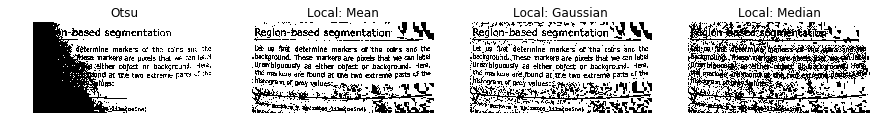

In [77]:
fig, ax = plt.subplots(1, 4, figsize=(15, 6))
ax[0].imshow(page_img >= threshold_otsu(page_img), cmap='gray')
ax[1].imshow(page_img >= threshold_local(page_img, 31, method='mean'), cmap='gray')
ax[2].imshow(page_img >= threshold_local(page_img, 31, method='gaussian'), cmap='gray')
ax[3].imshow(page_img >= threshold_local(page_img, 31, method='median'), cmap='gray')
for i in range(4): ax[i].set_axis_off()

for i, title in enumerate(["Otsu", "Local: Mean", "Local: Gaussian", "Local: Median"]): ax[i].set_title(title)

### Задание 2.

Подберите изображение, на котором обычная бинаризация даёт плохие результаты, когда как локальная позволяет получить результаты гораздо лучше. Найдите наиболее подходящие параметры метода `threshold_local`.

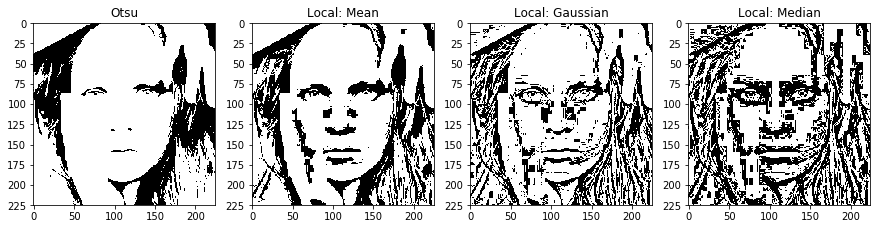

In [123]:
_local = imread('girl.jpg')
img_local = rgb2gray(_local)

fig, ax = plt.subplots(1, 4, figsize=(15, 6))
ax[0].imshow(img_local >= threshold_otsu(img_local), cmap='gray')
ax[1].imshow(img_local >= threshold_local(img_local, 31, method='mean'), cmap='gray')
ax[2].imshow(img_local >= threshold_local(img_local, 21, method='gaussian'), cmap='gray')
ax[3].imshow(img_local >= threshold_local(img_local, 15, method='median'), cmap='gray')

for i, title in enumerate(["Otsu", "Local: Mean", "Local: Gaussian", "Local: Median"]): ax[i].set_title(title)

## 2. Представления изображений

Посмотрим на преобразование Фурье:

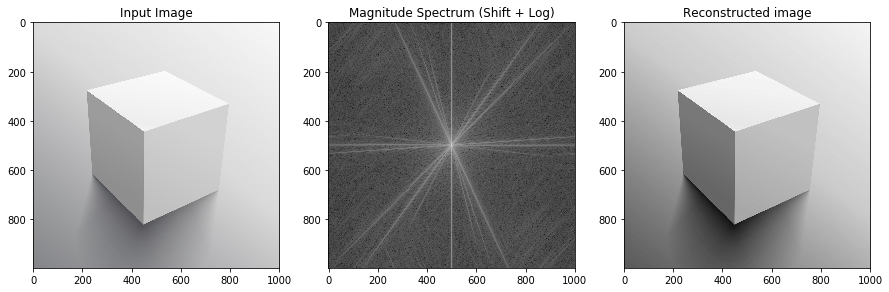

In [124]:
img = imread('cube.jpg')

f = np.fft.fft2(rgb2gray(img)) # вычисляем 2D-FFT для изображения
fshift = np.fft.fftshift(f)    # свдигаем нулевую частоту в центр
spectrum = 100 * np.log(np.abs(fshift))

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].set_title('Input Image')
ax[1].set_title('Magnitude Spectrum (Shift + Log)')
ax[2].set_title('Reconstructed image')

ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(spectrum, cmap = 'gray')

transformed_fshift = fshift.copy()
transformed_fshift[0:400, 0:200] = 0 # удалим куски, не содержащие светлых прямых на спектре, это не повлияет на рёбра куба
transformed_fshift[600:900, 800:1000] = 0
inv = np.fft.ifft2(np.fft.ifftshift(transformed_fshift)).real # восстановим изображение обратным преобразованием
ax[2].imshow(inv, cmap='gray')

Видно, что прямые на спектре соответствуют прямым на исходном изображении.

### Задание 3.

Подберите изображение, чтобы на его спектре была окружность.

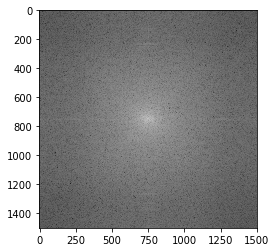

In [196]:
img_2 = imread('s.jpg')

plt.imshow(100 * np.log(np.abs(np.fft.fftshift(np.fft.fft2(rgb2gray(img_2))))), cmap='gray')

### Задание 4.

Достаточно часто возникает задача распознавания геометрических объектов (прямых, окружностей и т.п.)

Найдём границы куба с помощью преобразования Хаффа:

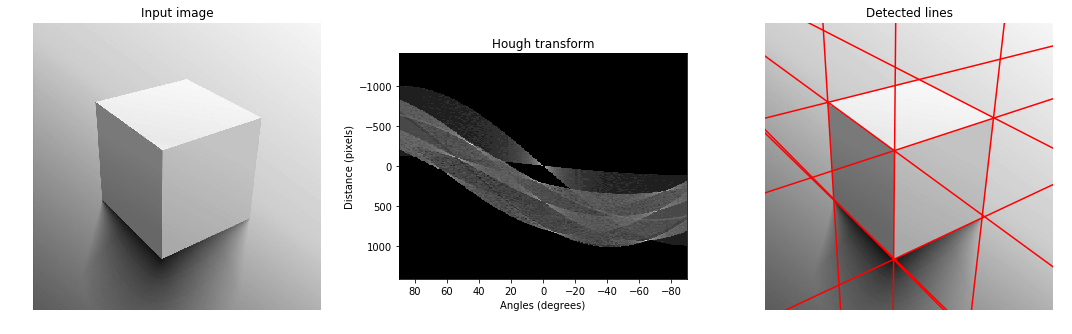

In [127]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny

from matplotlib import cm

def show_hough_transform(image):
    h, theta, d = hough_line(canny(image)) # вычисляем преобразование Хаффа от границ изображения

    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    ax[0].imshow(image, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    ax[1].imshow(np.log(1 + h),
                 extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
                 cmap='gray', aspect=1/20)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')

    ax[2].imshow(image, cmap=cm.gray)
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
        ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
    ax[2].set_xlim((0, image.shape[1]))
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    plt.tight_layout()
    plt.show()
    
cube = rgb2gray(imread('./cube.jpg'))
show_hough_transform(cube)

**Задание:**

Подберите изображение, на котором с помощью преобразования Хафа можно найти несколько прямых:

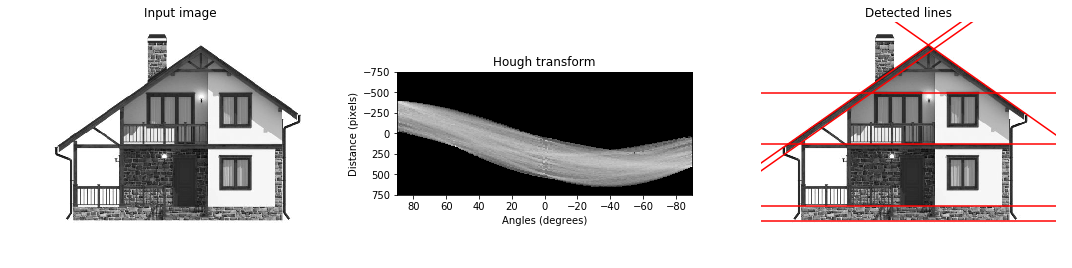

In [128]:
image_with_lines = rgb2gray(imread('house.jpg'))

show_hough_transform(image_with_lines)

## Поиск границ

Часто возникает задача поиска границ на изображении: они могут быть использованы для распознавания образов (Object Detection), сегментации и классификации изображений. Так, в предыдущей задаче поиск линий осуществлялся именно на карте границ, а не на исходном изображении.

Посмотрим на различные фильтры, помогающие при выделении границ:

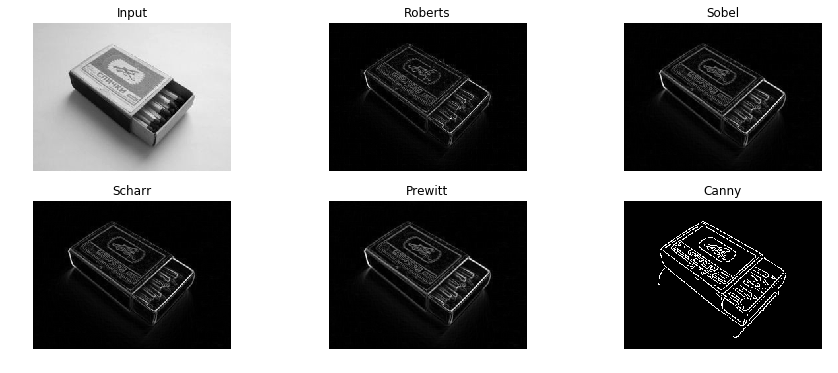

In [129]:
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.feature import canny

matchbox = rgb2gray(imread('matchbox.jpg')) # детекторы границ по умолчанию работают с одним каналом

fig, ax = plt.subplots(2, 3, figsize=(15, 6))
ax[0, 0].imshow(matchbox, cmap='gray')
ax[0, 1].imshow(roberts(matchbox), cmap='gray')
ax[0, 2].imshow(sobel(matchbox), cmap='gray')
ax[1, 0].imshow(scharr(matchbox), cmap='gray')
ax[1, 1].imshow(prewitt(matchbox), cmap='gray')
ax[1, 2].imshow(canny(matchbox), cmap='gray')
for i, title in enumerate(["Input", "Roberts", "Sobel", "Scharr", "Prewitt", "Canny"]): ax.flatten()[i].set_title(title)
for i in range(6): ax.flatten()[i].set_axis_off()

Фильтры Roberts, Sobel, Scharr, Prewitt вычисляют различные аппроксимации модуля градиента.

Детектор Canny - находит тонкие границы, соответствующие локальным максимумам модуля градиента. Поэтому зачастую граница состоит из набора коротких кривых. И для edge-based сегментации (выделения полного контура объекта) с помощью детектора Canny требуется подбирать параметры.

Выделим спичечный коробок на изображении двумя способами: с помощью карты границ, полученной детектором Canny, и с помощью так называемой region-based сегментации - методом [водораздела](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29), применяя аппроксимацию модуля градиента Собеля.

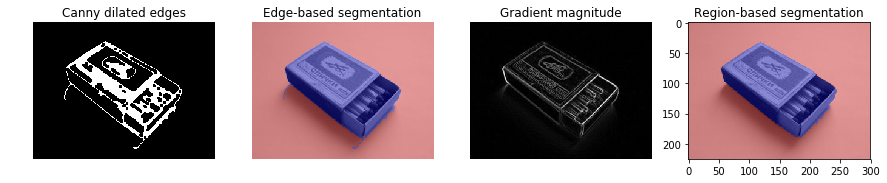

In [130]:
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import watershed, binary_closing, binary_erosion
from skimage.color import label2rgb

fig, ax = plt.subplots(1, 4, figsize=(15, 6))

canny_edge_map = binary_closing(canny(matchbox, sigma=1), selem=np.ones((4, 4)))
matchbox_edge_segmentation = binary_fill_holes(canny_edge_map)

ax[0].imshow(canny_edge_map, cmap='gray')
ax[1].imshow(label2rgb(matchbox_edge_segmentation, image=matchbox))

# поставим маркеры фона и объекта
markers = np.zeros_like(matchbox)
markers[0:10, 0:10] = 1 # маркеры фона
markers[binary_erosion(canny_edge_map) > 0] = 2 # маркеры объекта - точки, находящиеся заведомо внутри

sobel_gradient = sobel(matchbox)
matchbox_region_segmentation = watershed(sobel_gradient, markers)

ax[2].imshow(sobel_gradient, cmap='gray')
ax[3].imshow(label2rgb(matchbox_region_segmentation, image=matchbox))

for i, title in enumerate(["Canny dilated edges", "Edge-based segmentation", "Gradient magnitude", "Region-based segmentation"]): ax[i].set_title(title)
for i in range(3): ax[i].set_axis_off()

Визуально оба метода справились достаточно хорошо, но у каждого есть свои недостатки и преимущества:
* edge-based сегментация в данном случае дала не совсем корректный результат (в маску вошли две лишние кривые, идущие по тени), при этом вручную были подобраны параметры фильтра и ядра дилатации;
* для region-based пришлось вручную задать маркеры объекта - на практике такой информации могло бы и не быть.

### Задание 5.
* Подберите изображение, на котором можно выделить объект первым подходом (с помощью карты границ). При этом на изображении должен быть неоднородный фон;
* Найдите параметры детектора границ и морфологических операций, чтобы получить максимально точную маску.

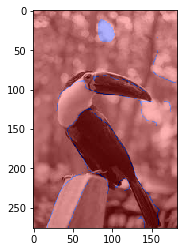

In [193]:
easy_to_segment = rgb2gray(imread('bird.jpg'))

my_edge_map = binary_closing(canny(easy_to_segment, sigma=6), selem=np.ones((4, 4)))
my_edge_segmentation = binary_fill_holes(my_edge_map)

plt.imshow(label2rgb(my_edge_segmentation, image=easy_to_segment))


## Особые точки 

Особые точки - один из основных механизмов извлечения признаков для распознавания образов и локализации заданного объекта на изображении.

Существует несколько типов особых точек и дескрипторов:
* инвариантные к сдвигу, масштабированию и повороту - SIFT, SURF, FAST;
* инвариантные к масштабированию, но не к повороту - U-SURF;
* не инвариантные к масштабированию - Blob (обычно дескрипторы описывают соответствующие точки, но с разным значением радиуса);
* и другие.

Посмотрим на результаты работы различных детекторов:

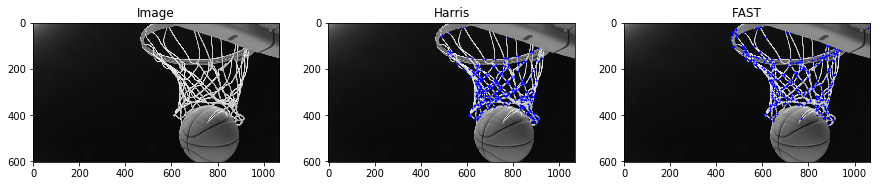

In [131]:
from skimage.feature import corner_harris, corner_peaks, corner_fast, corner_subpix
from skimage.transform import warp, AffineTransform

basketball = rgb2gray(imread("basketball.jpg"))

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].set_title('Image')
ax[0].imshow(basketball, cmap='gray')

# corner_harris возвращает матрицу, в которой максимумы соответствуют особым точкам
# поэтому чтобы извлечь координаты надо вызвать corner_peaks
basketball_harris = corner_peaks(corner_harris(basketball))
ax[1].set_title('Harris')
ax[1].imshow(basketball, cmap='gray')
ax[1].plot(basketball_harris[:, 1], basketball_harris[:, 0], '+b', markersize=2)

basketball_fast = corner_peaks(corner_fast(basketball))
ax[2].set_title('FAST')
ax[2].imshow(basketball, cmap='gray')
ax[2].plot(basketball_fast[:, 1], basketball_fast[:, 0], '+b', markersize=2)

Решим задачу стабилизации видеоряда: дана последовательность изображений (для простоты - два), требуется сделать так, чтобы объект занимал одно и то же положение в кадре.

Сначала сгенирируем данные искусственным образом: пусть камера немного повернулась против часовой стрелки и сдвинулась вверх.
Получим новую картинку поворотом старой на 3 градуса и сдвигом на 20 пикселей вправо и вниз, и посмотрим на особые точки:

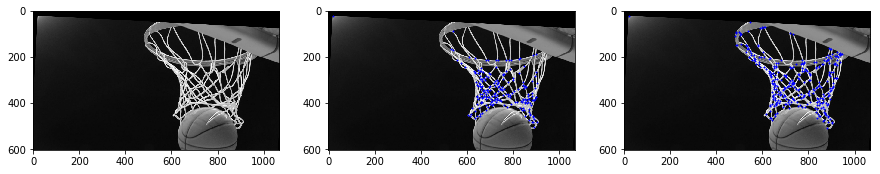

In [132]:
from skimage.transform import warp, AffineTransform

tform = AffineTransform(rotation=np.deg2rad(3), translation=(20, 20))
basketball2 = warp(basketball, tform.inverse, output_shape=basketball.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(basketball2, cmap='gray')

basketball2_harris = corner_peaks(corner_harris(basketball2))
ax[1].imshow(basketball2, cmap='gray')
ax[1].plot(basketball2_harris[:, 1], basketball2_harris[:, 0], '+b', markersize=2)

basketball2_fast = corner_peaks(corner_fast(basketball2))
ax[2].imshow(basketball2, cmap='gray')
ax[2].plot(basketball2_fast[:, 1], basketball2_fast[:, 0], '+b', markersize=2)

Видно, что часть особых точек находится в тех же местах объекта, где и была до поворота.

Найдём дескрипторы особых точек исходной и искажённой картинок, и сдвинем вторую картинку, чтобы она занимала исходное положение.

Для этого воспользуемся *ORB* - детектором (*Oriented FAST and rotated BRIEF*) и методом RANSAC для поиска аффинного преобразования, после чего применим обратное аффинное преобразование:

Оценка сдвига: [19.86942396 20.14332054]
Оценка поворота: -2.9986161682797223


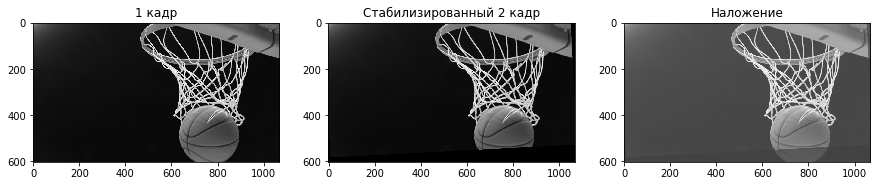

In [133]:
from skimage.feature import match_descriptors, ORB
from skimage.measure import ransac

orb = ORB()
orb.detect_and_extract(basketball)

orb2 = ORB()
orb2.detect_and_extract(basketball2)

basketball_match = match_descriptors(orb.descriptors, orb2.descriptors, cross_check=True)

src = orb.keypoints[basketball_match[:, 0]]
dst = orb2.keypoints[basketball_match[:, 1]]
    
estimated_transform, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=1000)

basketball3_stab = warp(basketball2, AffineTransform(translation=estimated_transform.translation,
                                                     rotation=-estimated_transform.rotation),
                        output_shape=basketball2.shape)


fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(basketball, cmap='gray')
ax[1].imshow(basketball3_stab, cmap='gray')
ax[2].imshow(basketball, cmap='gray', alpha=0.5)
ax[2].imshow(basketball3_stab, cmap='gray', alpha=0.5)

for i, title in enumerate(['1 кадр', 'Стабилизированный 2 кадр', 'Наложение']): ax[i].set_title(title)

print(f"Оценка сдвига: {estimated_transform.translation}")
print(f"Оценка поворота: {np.rad2deg(estimated_transform.rotation)}")

Видно, что подход работает достаточно хорошо, поэтому его часто применяют для решения аналогичных задач на практике. Существуют и другие подходы к решению данной задачи: оценка оптического потока (Optical Flow), и сопоставление с шаблоном с помощью преобразования Фурье.

Точно такую же технику можно использовать для решения задачи поиска гомографии, в частности - проективного преобразования, то есть для поиска отображения, преобразующего шаблонное изображение (например, qr-код) в объект на другом заданном изображении (снимке с камеры). С помощью найденной (или не найденной) гомографии можно установить есть ли объект на изображении, где он находится; исправить перспективу; отрендерить 3d-объект, чтобы он реалистично вписывался в сцену (AR), и другое.